In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, ToPILImage, Resize
from torch import nn

In [2]:
import os
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
from PIL import Image as pilimage

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random

In [3]:
class Person:
    def __init__(self, name):
        self.name = name
        self.new = []
        self.old = []
        self.resize = Resize((224, 224))

    def add(self, age, num):
        pic = self.resize(
                  pilimage.open('../data/CACD2000/'+ str(age) + '_' + self.name + '_' + str(num) + '.jpg') #TODO format
              )
        if int(age) > 30:
            self.old.append(pic)
        else:
            self.new.append(pic)
            
    def get_old(self):
        return random.sample(self.old, 1)[0]
    def get_new(self):
        return random.sample(self.new, 1)[0]

In [4]:
# class Image:
#     def __init__(self, age, fname, sname, num):
#         self.age = age
#         self.fname = fname
#         self.sname = sname
#         self.num = num
#         self.image = None
#         self.resize = Resize((224, 224))
        
#     def get_pilimage(self):
#         if self.image is None:
#             self.image = pilimage.open(
#                 '../data/CACD2000/'+'_'.join([self.age, self.fname, self.sname, self.num]) + '.jpg'
#             )
#         return self.resize(self.image)
    
#     def get_timage(self):
#         if self.image is None:
#             self.image = pilimage.open(
#                 '../data/CACD2000/'+'_'.join([self.age, self.fname, self.sname, self.num]) + '.jpg'
#             )
#         return ToTensor()(self.resize(self.image))


In [5]:
os.listdir('../data/CACD2000/')[:5]

['14_Aaron_Johnson_0001.jpg',
 '14_Aaron_Johnson_0002.jpg',
 '14_Adelaide_Kane_0001.jpg',
 '14_Adelaide_Kane_0002.jpg',
 '14_Adelaide_Kane_0003.jpg']

In [6]:
persons = {}
errnum = 0
for image in tqdm(os.listdir('../data/CACD2000/')):
    try:
        info = image[:-4].split('_')
        name = '_'.join(info[1:-1])
        try:
            persons[name].add(info[0], info[-1])
        except Exception:
            persons[name] = Person(name)
            persons[name].add(info[0], info[-1])
    except Exception as e:
        print(e)
        if errnum > 10:
            break
        errnum += 1
errnum

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [7]:
name

'Greta_Scacchi'

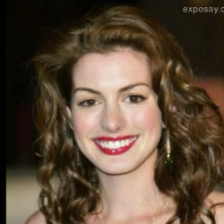

In [8]:
im = persons['Anne_Hathaway'].get_new()
im

In [9]:
class AgeDataset(Dataset):
    def __init__(self, persons):
        self.persons = persons
        self.keys = list(persons.keys())
        
    def __len__(self):
        return len(self.persons)
    
    def __getitem__(self, ind):
        flag = 1
        while flag:
            pers = random.sample(self.keys, 1)[0]
            pers = persons[pers]
            try:
                new = pers.get_new()
                old = pers.get_old()
            except ValueError:
                continue
            flag = 0
        return ToTensor()(new), ToTensor()(old)
        # return new, old

In [10]:
ageset = AgeDataset(persons)
ageloader = DataLoader(ageset, batch_size=32)

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 9, 1, 4),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.ress = nn.ModuleList([nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )] * 4)
        self.upconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 12, 1, 4),
        )
    
    def forward(self, x): # херня с резблоками
        x = self.conv(x)
        for conv in self.ress:
            x = conv(x) + x
        return self.upconv(x)

In [12]:
# del generator
# del new
# del old
# del optim
# torch.cuda.empty_cache()


In [13]:
generator = Generator().cuda()
criterion = nn.MSELoss()
optim = torch.optim.Adam(generator.parameters())

In [ ]:
losses = []
generator.train()

for epoch in tqdm(range(1000), desc='epoch'):
    for new, old in tqdm(ageloader, leave=False, desc='train'):
        new, old = new.cuda(), old.cuda()
        optim.zero_grad()
        old_gen = generator(new)
        loss = criterion(old_gen, old)
        loss.backward()
        optim.step()
#         losses.append(loss.item())
#     plt.plot(losses)
#     plt.show()


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
ageloader_eval = DataLoader(ageset, batch_size=1)

In [ ]:
generator.eval()
i = 0
for new, old in tqdm(ageloader_eval):
    i+=1
    new = new.cuda()
    old_gen = generator(new)
    plt.subplot(1,3,1)
    plt.title('new')
    plt.imshow(new.cpu().data.numpy()[0].swapaxes(0, 2).swapaxes(0, 1))
    plt.subplot(1,3,2)
    plt.title('old')
    plt.imshow(old.data.numpy()[0].swapaxes(0, 2).swapaxes(0, 1))
    plt.subplot(1,3,3)
    plt.title('old generated')
    plt.imshow(old_gen.cpu().data.numpy()[0].swapaxes(0, 2).swapaxes(0, 1))
    plt.show()
    if i > 20:
        break

In [ ]:
1

In [48]:
o = old_gen.cpu().data.numpy()[0]

In [50]:
o.swapaxes(0, 2).swapaxes(0, 1)

(224, 224, 3)

In [47]:
old_gen.cpu().data.numpy()[0]..shape

(3, 224, 224)

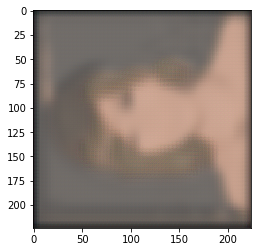

In [52]:
plt.imshow(o.swapaxes(0, 2))

In [36]:
torch.cuda.empty_cache()

In [16]:
new.shape

torch.Size([32, 3, 224, 224])

In [17]:
old.shape

torch.Size([32, 3, 224, 224])

In [18]:
old_gen.shape

torch.Size([32, 3, 221, 221])